# Duomenu aibes aprasymas, transformacijos

#### Importuojame paketus, paruošiame grafikų stilių

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import contextily as cx

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

## Importuojam duomenis

In [111]:
df = pd.read_csv(
    'aisdk-2026-02-05.csv',
    engine='pyarrow'
)

In [112]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 15750590 entries, 0 to 15750589
Data columns (total 26 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   # Timestamp                     str    
 1   Type of mobile                  str    
 2   MMSI                            int64  
 3   Latitude                        float64
 4   Longitude                       float64
 5   Navigational status             str    
 6   ROT                             float64
 7   SOG                             float64
 8   COG                             float64
 9   Heading                         float64
 10  IMO                             str    
 11  Callsign                        str    
 12  Name                            str    
 13  Ship type                       str    
 14  Cargo type                      str    
 15  Width                           float64
 16  Length                          float64
 17  Type of position fixing device  str 

## Filtruojam geografinį regioną, navigacinį statusą, `Type of mobile`

In [113]:
df_filtered = df[
    df['Latitude'].between(54, 56) &
    df['Longitude'].between(12, 17) &
    (df['Navigational status'] == 'Under way using engine') &
    (df['Type of mobile'] == 'Class A')
].copy(deep=True)

del df

#### Vizualizuojam geografinį regioną

## Ištiriam nelogiškas ar nereikalingas reikšmes

In [114]:
df_filtered['Ship type'].value_counts()

Ship type
Cargo              684262
Passenger          263383
Tanker             246091
Pilot              110811
SAR                 92871
Fishing             59486
Other               45911
Dredging            41171
HSC                 40135
Undefined           38660
Tug                 38111
Towing              12116
Spare 1             11088
Law enforcement      8943
Military              153
Name: count, dtype: int64

> `Undefined` nereikia: mums reikia tik laivų, kuriu tipas yra žinomas, kad juos galėtume klasifikuoti, klasterizuoti ir t.t.

In [115]:
df_filtered = df_filtered[ ~(df_filtered['Ship type'] == 'Undefined') ]

In [116]:
numerical = ['ROT', 'SOG', 'COG', 'Heading']
df_filtered[numerical].max()

ROT       697.500
SOG       102.200
COG       359.900
Heading   359.000
dtype: float64

In [117]:
df_filtered[numerical].min()

ROT       -231.400
SOG          0.000
COG          0.000
Heading      0.000
dtype: float64

<Axes: xlabel='SOG', ylabel='Ship type'>

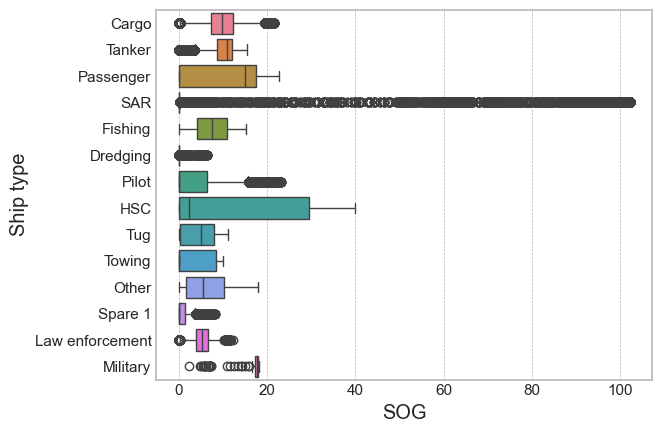

In [118]:
sns.boxplot(y='Ship type', x='SOG', hue='Ship type', data=df_filtered)

> Išskirtinai didelis SOG (100 mazgų ~ 185 kmh) yra paieškos ir gelbėjimo (*angl. Save and rescue, SAR*) laivo, kas, kontekste, nėra nelogiškas greitis

### Ištiriam praleistas reikšmes, skirtumus tarp stebėjimų

Čia mūsų siekis bus dvejopas:
1. Susitvarkyti su praleistomis reikšmėmis;
2. Išplėsti laiko eilutes į lygiai vienos minutės intervalus, t. y, padaryti taip, kad tarp vieno laivo AIS signalų visą laiką būtų vienos minutės skirtumas.

In [119]:
df_filtered[numerical].isnull().sum()

ROT        380882
SOG          2111
COG         46301
Heading    130393
dtype: int64

### Heading praleistos reikšmės

In [120]:
output = []

for ship_type, type_data in df_filtered.groupby('Ship type'):

    for col in numerical:
        output.append({
            'Laivo tipas': ship_type,
            'Kintamasis': col,
            'Praleistų reikšmių dalis, %': type_data[col].isnull().mean() * 100
        })

pd.DataFrame(output).pivot(columns=['Kintamasis'], index=['Laivo tipas'])

Praleistų reikšmių dalis, %                     
Kintamasis                              COG Heading    ROT   SOG
Laivo tipas                                                     
Cargo                                 0.013   3.129 17.574 0.012
Dredging                             15.904   0.000  2.992 0.000
Fishing                               0.000   0.000 29.578 0.000
HSC                                   0.000   0.000 18.146 0.000
Law enforcement                       0.000   8.185 20.183 0.000
Military                              0.000   0.000  0.000 0.000
Other                                 0.331   0.163 38.546 0.015
Passenger                             0.749  11.197 16.498 0.749
Pilot                                 0.005  10.355 49.013 0.005
SAR                                  40.409  72.360 73.208 0.039
Spare 1                               0.000   0.000 23.909 0.000
Tanker                                0.002   0.004  9.891 0.002
Towing                                0.000   0.000 18.752 0.000
Tug                                   0.003   0.000 52.470 0.003

> Kadangi SAR tipo laivai turi virš 50 % praleistų reikšmių `Heading` ir `ROT` kintamuosiuose, šitą laivo tipą išimsime. Taip pat išimsime Tug laivo tipą, kadangi jo `ROT` požymis turi virš 50 % praleistų reikšmių

In [121]:
df_filtered = df_filtered[
    ~( (df_filtered['Ship type'] == 'SAR') | 
       (df_filtered['Ship type'] == 'Tug') )
]

#### Praleistų reikšmių skaičius/dalis kiekvienam kintamajam

In [122]:
df_filtered[numerical].isnull().agg(['sum', 'mean'])

,ROT,SOG,COG,Heading
sum,292896.000,2074.000,8772.000,63192.000
mean,0.192,0.001,0.006,0.041


> Toliau patikrinsime ar yra laivų, kurių kuriame nors AIS signalų rinkinyje yra 100 % praleistų reikšmių

In [123]:
for mmsi, mmsi_data in df_filtered.groupby('MMSI'):

    if any( df_filtered[numerical].isnull().mean() >= 1 ):
        print(mmsi)

> Toliau reikia ištirti ar laiko skirtumas tarp stebėjimų neviršija 2 valandų (literatūroje taikyta riba)

In [124]:
from datetime import timedelta

In [125]:
df_filtered['# Timestamp'] = pd.to_datetime( df_filtered['# Timestamp'] )

In [126]:
rm_mmsi = []
for mmsi, mmsi_data in df_filtered.groupby('MMSI'):

    mmsi_data = mmsi_data.sort_values('# Timestamp')

    time_diff = mmsi_data['# Timestamp'].diff(1)
    max_time_diff = time_diff.max()

    if max_time_diff >= timedelta(hours=2):
        rm_mmsi.append(mmsi)

print(f'Pašalinsime {len(rm_mmsi)} laivų')

Pašalinsime 33 laivų


In [127]:
is_mmsi_removed = df_filtered['MMSI'].isin( set(rm_mmsi) )
df_filtered = df_filtered[ ~is_mmsi_removed ]

## isskirtys

In [128]:

numerical_cols = ["ROT", "SOG", "COG", "Heading"]
for col in numerical_cols:
    df_col = df_filtered[col]
    
    Q1 = df_col.quantile(0.25)
    Q3 = df_col.quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = df_filtered[(df_filtered[col] < lower) | (df_filtered[col] > upper)]
    
    print(f"\n{col}")
    print("Lower:", round(lower, 2))
    print("Upper:", round(upper, 2))
    print("Min:", round(df_col.min(), 2))
    print("Max:", round(df_col.max(), 2))
    print("Outliers:", len(outliers))



ROT
Lower: 0.0
Upper: 0.0
Min: -116.1
Max: 237.9
Outliers: 249968

SOG
Lower: -7.05
Upper: 22.95
Min: 0.0
Max: 27.1
Outliers: 230

COG
Lower: -193.75
Upper: 510.65
Min: 0.0
Max: 359.9
Outliers: 0

Heading
Lower: -188.5
Upper: 511.5
Min: 0.0
Max: 359.0
Outliers: 0


In [129]:
numerical_cols = ["ROT", "SOG"]

for ship_type, group in df_filtered.groupby("Ship type"):
    
    print(f"\n===== Ship type: {ship_type} =====")
    
    for col in numerical_cols:
        df_col = group[col].dropna()
        
        Q1 = df_col.quantile(0.25)
        Q3 = df_col.quantile(0.75)
        IQR = Q3 - Q1
        
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        outliers = group[(group[col] < lower) | (group[col] > upper)]
        
        print(f"\n{col}")
        print("Q1:", round(Q1, 2))
        print("Q3:", round(Q3, 2))
        print("Lower:", round(lower, 2))
        print("Upper:", round(upper, 2))
        print("Min:", round(df_col.min(), 2))
        print("Max:", round(df_col.max(), 2))
        print("Outliers:", len(outliers))



===== Ship type: Cargo =====

ROT
Q1: 0.0
Q3: 0.0
Lower: 0.0
Upper: 0.0
Min: -86.4
Max: 237.9
Outliers: 136532

SOG
Q1: 7.4
Q3: 11.9
Lower: 0.65
Upper: 18.65
Min: 0.0
Max: 21.2
Outliers: 39208

===== Ship type: Dredging =====

ROT
Q1: 0.0
Q3: 0.0
Lower: 0.0
Upper: 0.0
Min: 0.0
Max: 0.0
Outliers: 0

SOG
Q1: 0.0
Q3: 0.0
Lower: 0.0
Upper: 0.0
Min: 0.0
Max: 6.4
Outliers: 3755

===== Ship type: Fishing =====

ROT
Q1: 0.0
Q3: 0.0
Lower: 0.0
Upper: 0.0
Min: 0.0
Max: 0.0
Outliers: 0

SOG
Q1: 4.1
Q3: 10.9
Lower: -6.1
Upper: 21.1
Min: 0.0
Max: 15.2
Outliers: 0

===== Ship type: HSC =====

ROT
Q1: 0.0
Q3: 0.0
Lower: 0.0
Upper: 0.0
Min: 0.0
Max: 0.0
Outliers: 0

SOG
Q1: 0.0
Q3: 0.0
Lower: 0.0
Upper: 0.0
Min: 0.0
Max: 27.1
Outliers: 3568

===== Ship type: Law enforcement =====

ROT
Q1: 0.0
Q3: 0.0
Lower: 0.0
Upper: 0.0
Min: 0.0
Max: 0.0
Outliers: 0

SOG
Q1: 4.0
Q3: 6.5
Lower: 0.25
Upper: 10.25
Min: 0.0
Max: 11.5
Outliers: 1215

===== Ship type: Military =====

ROT
Q1: -7.5
Q3: 3.6
Lower: -24.15
Up

Taikant IQR metodą nustatyta, kad kintamasis ROT turi labai daug išskirčių. Tačiau tai paaiškinama tuo, kad didžioji dalis stebėjimų turi reikšmę 0 (laivas juda tiesiai), todėl kvartilių intervalas lygus nuliui ir visi nenuliniai stebėjimai klasifikuojami kaip išskirtys. Todėl pasirinkome išskirčių nešalinti.


# isimt ROT = 0 ir su boxplotu patikrint isskirtis

In [130]:
df_isskirciu = df_filtered.copy()
df_isskirciu = df_isskirciu[df_isskirciu["ROT"] != 0]


In [131]:

numerical_cols = ["ROT", "SOG", "COG", "Heading"]
for col in numerical_cols:
    df_col = df_isskirciu[col]
    
    Q1 = df_col.quantile(0.25)
    Q3 = df_col.quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = df_isskirciu[(df_isskirciu[col] < lower) | (df_isskirciu[col] > upper)]
    
    print(f"\n{col}")
    print("Lower:", round(lower, 2))
    print("Upper:", round(upper, 2))
    print("Min:", round(df_col.min(), 2))
    print("Max:", round(df_col.max(), 2))
    print("Outliers:", len(outliers))



ROT
Lower: -11.6
Upper: 11.6
Min: -116.1
Max: 237.9
Outliers: 28382

SOG
Lower: -7.95
Upper: 24.45
Min: 0.0
Max: 27.1
Outliers: 93

COG
Lower: -171.55
Upper: 501.65
Min: 0.0
Max: 359.9
Outliers: 0

Heading
Lower: -166.0
Upper: 490.0
Min: 0.0
Max: 359.0
Outliers: 0


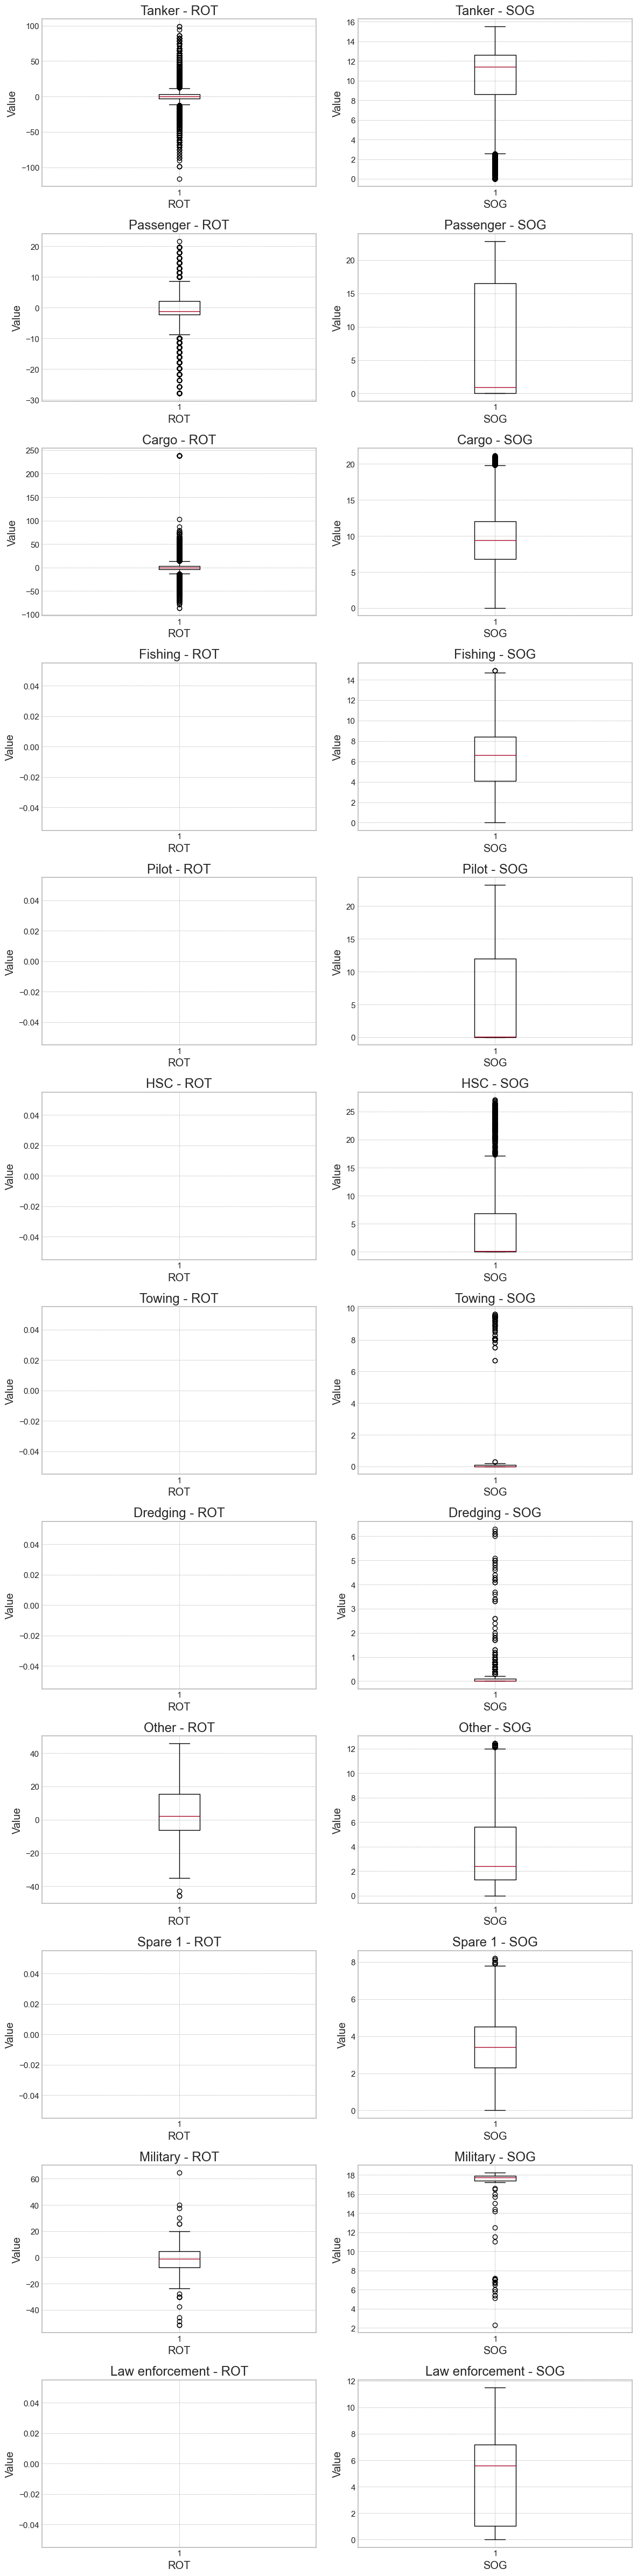

In [132]:
import matplotlib.pyplot as plt
import math

numerical_cols = ["ROT", "SOG"]

ship_types = df_isskirciu["Ship type"].dropna().unique()
n_ship_types = len(ship_types)
n_cols = len(numerical_cols)

# Grid dimensijos
rows = n_ship_types
cols = n_cols

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))

# Jei tik vienas ship type arba vienas column – sutvarkome indexing
if rows == 1:
    axes = [axes]
if cols == 1:
    axes = [[ax] for ax in axes]

for i, ship_type in enumerate(ship_types):
    group = df_isskirciu[df_isskirciu["Ship type"] == ship_type]
    
    for j, col in enumerate(numerical_cols):
        ax = axes[i][j]
        
        ax.boxplot(group[col].dropna())
        ax.set_title(f"{ship_type} - {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Value")

plt.tight_layout()
plt.show()


In [133]:
filtered = df_isskirciu.loc[
    df_isskirciu["ROT"] > 150,
    # df_isskirciu["MMSI"] == 209325000,
    ["Ship type", "ROT", "Longitude", "Latitude", "# Timestamp", "MMSI"]
]

print(filtered)


         Ship type     ROT  Longitude  Latitude         # Timestamp       MMSI
15312846     Cargo 237.900     12.207    55.458 2026-05-02 23:20:14  209325000
15314616     Cargo 237.900     12.207    55.458 2026-05-02 23:20:24  209325000
15314618     Cargo 237.900     12.207    55.458 2026-05-02 23:20:24  209325000
15316491     Cargo 237.900     12.206    55.458 2026-05-02 23:20:34  209325000
15316495     Cargo 237.900     12.206    55.458 2026-05-02 23:20:34  209325000
15318387     Cargo 237.900     12.206    55.458 2026-05-02 23:20:44  209325000
15318390     Cargo 237.900     12.206    55.458 2026-05-02 23:20:44  209325000
15320825     Cargo 237.900     12.206    55.458 2026-05-02 23:20:57  209325000
15322642     Cargo 237.900     12.206    55.458 2026-05-02 23:21:07  209325000
15322649     Cargo 237.900     12.206    55.458 2026-05-02 23:21:07  209325000
15324613     Cargo 237.900     12.205    55.458 2026-05-02 23:21:17  209325000
15324616     Cargo 237.900     12.205    55.458 2026

In [134]:
import folium
import pandas as pd

# Filtruojame
filtered = df_isskirciu.loc[
    df_isskirciu["MMSI"] == 209325000,
    ["Longitude", "Latitude", "# Timestamp"]
].copy()

filtered["# Timestamp"] = pd.to_datetime(filtered["# Timestamp"])
filtered = filtered.sort_values("# Timestamp")

# Centro koordinatė
center_lat = filtered["Latitude"].mean()
center_lon = filtered["Longitude"].mean()

# Sukuriame žemėlapį
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Trajektorijos linija
coordinates = list(zip(filtered["Latitude"], filtered["Longitude"]))
folium.PolyLine(coordinates).add_to(m)

# Pradžios taškas
folium.Marker(
    coordinates[0],
    popup="Start",
    icon=folium.Icon(icon="play")
).add_to(m)

# Pabaigos taškas
folium.Marker(
    coordinates[-1],
    popup="End",
    icon=folium.Icon(icon="stop")
).add_to(m)
m.save("trajectory_map.html")




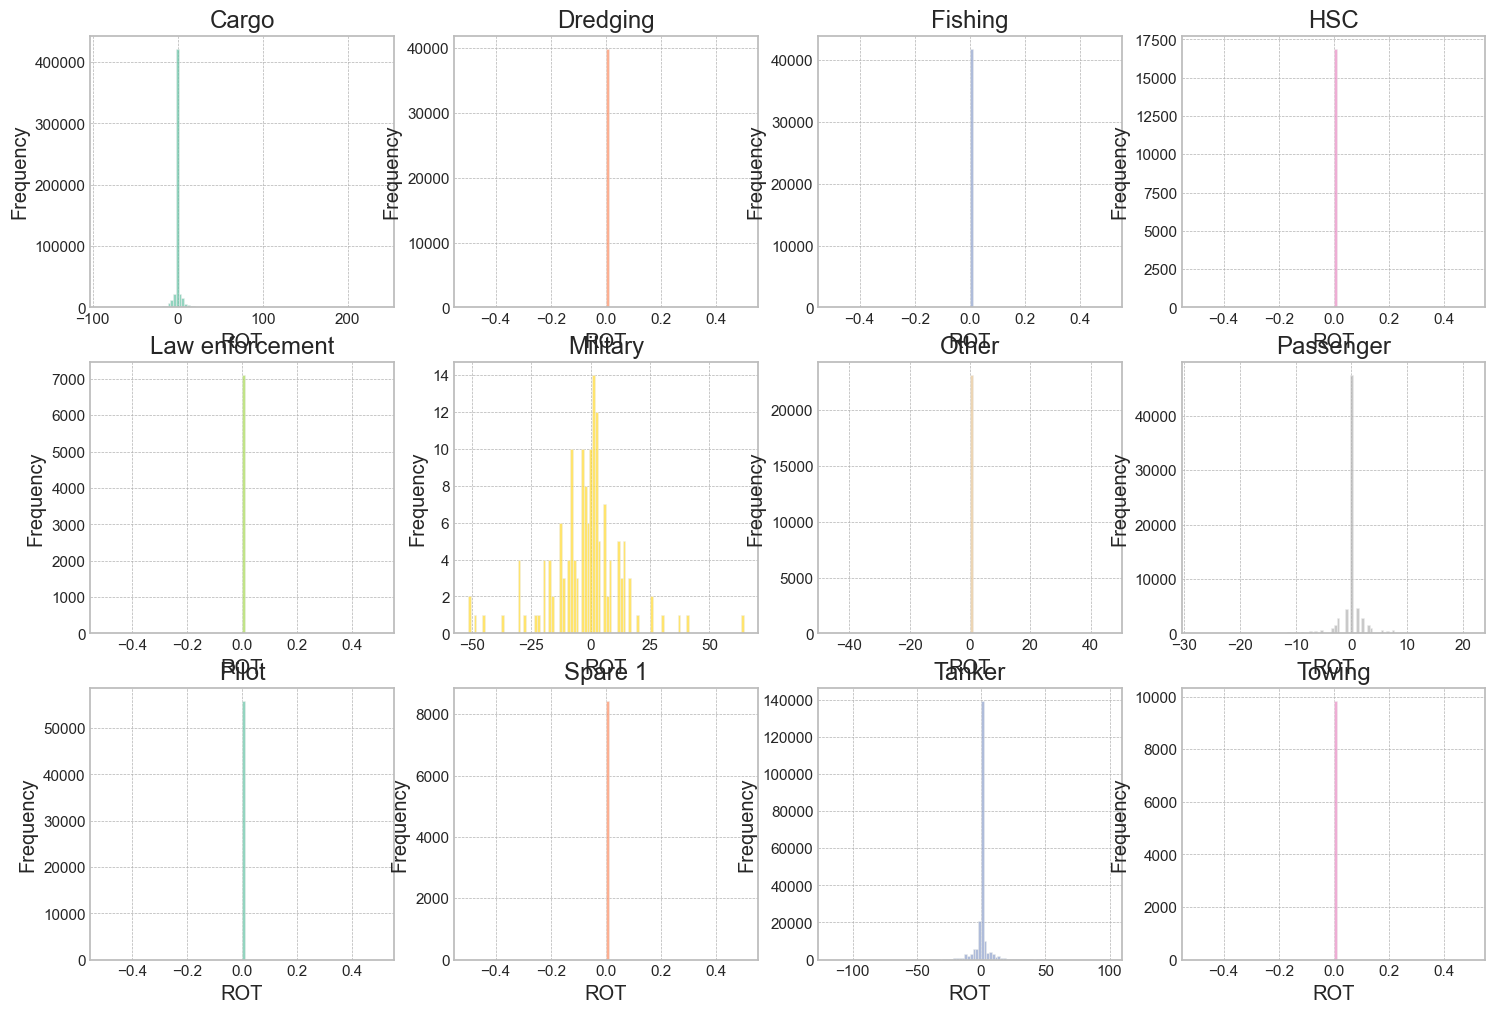

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ship_groups = [
    (ship_type, df_type)
    for ship_type, df_type in df_filtered.groupby("Ship type")
    #if len(df_type) >= 1000
]

n = len(ship_groups)

cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()

palette = sns.color_palette("Set2", n)

for i, ((ship_type, df_type), color) in enumerate(zip(ship_groups, palette)):
    axes[i].hist(
        df_type["ROT"],
        bins=100,
        color=color,
        alpha=0.7
    )
    axes[i].set_title(ship_type)
    axes[i].set_xlabel("ROT")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


<Figure size 640x480 with 0 Axes>

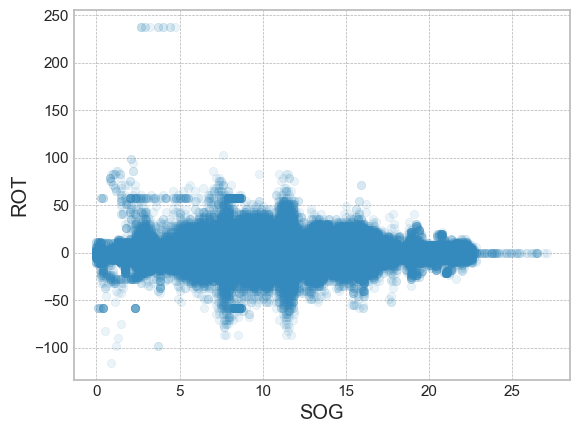

In [136]:

plt.suptitle("ROT Distribution by Ship Type", fontsize=16)
plt.tight_layout()
plt.show()
plt.scatter(df_filtered["SOG"], df_filtered["ROT"], alpha=0.1)
plt.xlabel("SOG")
plt.ylabel("ROT")
plt.show()

### Praleistų reikšmių užpildymas: kubinė interpoliacija

In [137]:
dfs = []
tarpai = []
praleistu_count = 0

for mmsi, mmsi_df in df_filtered.groupby('MMSI'):

    tarpai.extend( mmsi_df['# Timestamp'].diff(1).dropna().to_list() )
    
    # Atliekam transformacijq
    mmsi_df['Heading'] = mmsi_df['Heading']\
        .apply(lambda x: 360 - x if x > 180.0 else x)
    mmsi_df['COG'] = mmsi_df['COG']\
        .apply(lambda x: 360 - x if x > 180.0 else x)

    # Išplėčiame ir interpoliuojame
    output_df = mmsi_df.set_index('# Timestamp')\
        [['Latitude', 'Longitude', 'ROT', 'SOG', 'COG', 'Heading']]\
        .resample('60s')\
        .median()

    praleistu_count += output_df.isnull().sum()
    
    output_df = output_df\
        .interpolate('pchip')\
        .reset_index()

    # Ištaisome klaidas
    output_df['Heading'] = np.clip(output_df['Heading'], 0, 360)
    output_df['COG'] = np.clip(output_df['COG'], 0, 360)
    output_df['Latitude'] = np.clip(output_df['Latitude'], 54.0, 56.0)
    output_df['Longitude'] = np.clip(output_df['Longitude'], 12.0, 17.0)

    # Apskaičiuojame komponentes
    output_df['dist_x'] = output_df['Latitude'].diff(1).abs()
    output_df['dist_y'] = output_df['Longitude'].diff(1).abs()

    # Priskiriame MMSI ir laivo tipo reikšmes, nes šiuo metu jų nėra output_df
    output_df['MMSI'] = mmsi
    output_df['Ship type'] = mmsi_df['Ship type'].values[0]

    # Surenkame
    dfs.append(output_df)

data = pd.concat(dfs, ignore_index=True).dropna()

In [138]:
tarpai = np.array(tarpai)
tarpai = tarpai[ tarpai != 0 ]

np.quantile(tarpai, [0.05, 0.95])

array([Timedelta('0 days 00:00:00'), Timedelta('0 days 00:00:20')],
      dtype=object)

> Tarpai tarp AIS stebėjimų yra 0 - 20 sekundžių

In [139]:
praleistu_count / data.shape[0]

Latitude    0.055
Longitude   0.055
ROT         0.141
SOG         0.057
COG         0.059
Heading     0.127
dtype: float64

> Interpoliuota nuo 5 iki 15 % reikšmių priklausomai nuo požymio

In [140]:
print('Stebėjimų skaičius', data.shape[0])
print('Laivų skaičius', data['MMSI'].nunique())

Stebėjimų skaičius 151384
Laivų skaičius 277


## Rinkinio peržiūra

In [141]:
data = data.sort_values(['MMSI', '# Timestamp'])

In [142]:
data.head()

,# Timestamp,Latitude,Longitude,ROT,SOG,COG,Heading,dist_x,dist_y,MMSI,Ship type
1,2026-05-02 17:01:00,55.676,15.926,0.000,11.800,94.600,95.000,0.000,0.006,209221000,Tanker
2,2026-05-02 17:02:00,55.675,15.920,0.000,11.700,96.000,96.000,0.000,0.006,209221000,Tanker
3,2026-05-02 17:03:00,55.675,15.915,0.000,11.850,91.850,93.500,0.000,0.005,209221000,Tanker
4,2026-05-02 17:04:00,55.675,15.911,0.000,11.900,92.350,96.000,0.000,0.004,209221000,Tanker
5,2026-05-02 17:05:00,55.675,15.904,0.000,11.900,96.150,95.500,0.000,0.007,209221000,Tanker


In [143]:
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude), crs="EPSG:4326"
)

##### Pavyzdinė tanklaivio judėjimo trajektorija

Text(0.5, 1.0, 'Laivas ID 538007403, 2026-02-05 00:05-13:04')

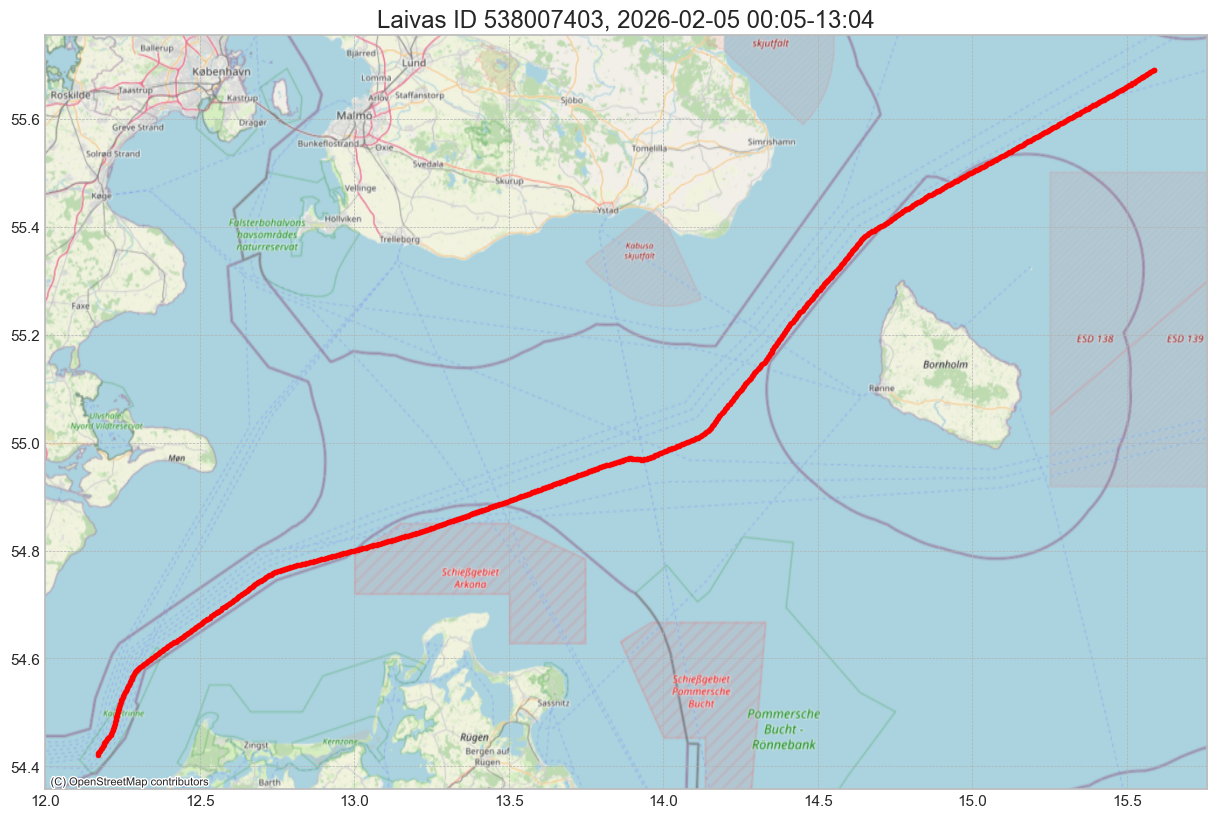

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

gdf[gdf.MMSI == 538007403].plot(ax=ax, markersize=12, color='red')

cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=9)

plt.title('Laivas ID 538007403, 2026-02-05 00:05-13:04')

# plt.savefig('plots/1lab/path1.png', format='png', dpi=300, bbox_inches="tight")

##### Pavyzdinė krovininio laivo judėjimo trajektorija

Text(0.5, 1.0, 'Laivas ID 636022047, 2026-02-05 06:22-18:04')

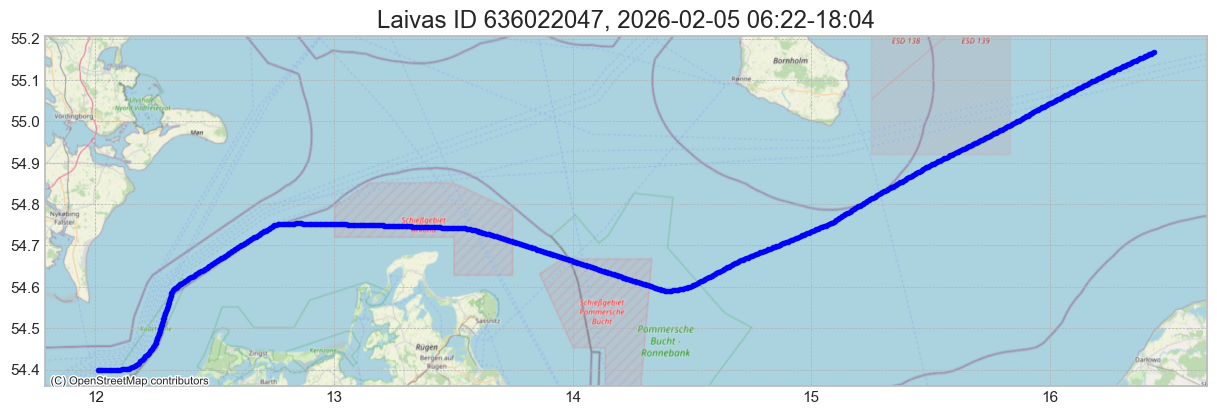

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

gdf[gdf.MMSI == 636022047].plot(ax=ax, markersize=12, color='blue')

cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=9)

plt.title('Laivas ID 636022047, 2026-02-05 06:22-18:04')

# plt.savefig('plots/1lab/path2.png', format='png', dpi=600, bbox_inches="tight")

### Reikšmių normavimas

In [146]:
data.describe()

,# Timestamp,Latitude,Longitude,ROT,SOG,COG,Heading,dist_x,dist_y,MMSI
count,151384,151384.000,151384.000,151384.000,151384.000,151384.000,151384.000,151384.000,151384.000,151384.000
mean,2026-05-02 11:47:46.068540,55.124,13.754,0.009,7.963,88.540,89.066,0.001,0.003,294083784.668
min,2026-05-02 00:01:00,54.115,12.000,-66.700,0.000,0.000,0.000,0.000,0.000,209221000.000
25%,2026-05-02 05:58:00,54.737,12.702,0.000,4.550,59.600,65.000,0.000,0.001,219026443.000
50%,2026-05-02 11:36:00,55.166,13.665,0.000,8.800,89.650,88.500,0.001,0.003,253361000.000
75%,2026-05-02 17:35:00,55.544,14.713,0.000,11.300,117.900,117.000,0.002,0.005,304323000.000
max,2026-05-02 23:59:00,56.000,16.438,75.000,26.000,180.000,180.000,0.010,0.024,667002348.000
std,NaN,0.451,1.140,2.361,5.096,42.266,40.209,0.001,0.002,122572882.218


In [147]:
data['ROT'] = np.arcsinh(data['ROT'])

In [148]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical = ['Latitude', 'Longitude', 'ROT', 'SOG', 'COG', 'Heading', 'dist_x', 'dist_y']
print(scaler.fit(data[numerical]))

StandardScaler()


In [149]:
data[numerical] = scaler.transform(data[numerical])

In [150]:
data.describe()

,# Timestamp,Latitude,Longitude,ROT,SOG,COG,Heading,dist_x,dist_y,MMSI
count,151384,151384.000,151384.000,151384.000,151384.000,151384.000,151384.000,151384.000,151384.000,151384.000
mean,2026-05-02 11:47:46.068540,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,294083784.668
min,2026-05-02 00:01:00,-2.238,-1.539,-6.784,-1.563,-2.095,-2.215,-1.022,-1.304,209221000.000
25%,2026-05-02 05:58:00,-0.860,-0.923,-0.003,-0.670,-0.685,-0.599,-0.904,-0.947,219026443.000
50%,2026-05-02 11:36:00,0.092,-0.078,-0.003,0.164,0.026,-0.014,-0.220,0.018,253361000.000
75%,2026-05-02 17:35:00,0.930,0.842,-0.003,0.655,0.695,0.695,0.568,0.682,304323000.000
max,2026-05-02 23:59:00,1.941,2.355,6.940,3.539,2.164,2.262,8.880,9.190,667002348.000
std,NaN,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,122572882.218


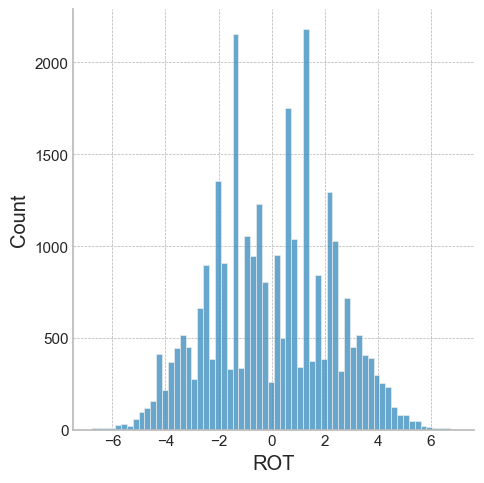

In [151]:
sns.displot(data[data.ROT != data.ROT.median()]['ROT'])

<Axes: ylabel='ROT'>

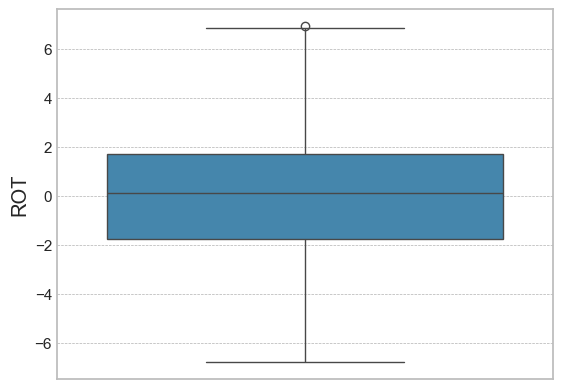

In [152]:
sns.boxplot(data[data.ROT != data.ROT.median()]['ROT'])

### Koreliacijos

In [153]:
numerical = ['ROT', 'SOG', 'COG', 'Heading', 'dist_x', 'dist_y']

In [154]:
corr = data[numerical]\
    .select_dtypes(include=['float64'])\
    .corr(method='spearman')

In [155]:
corr

,ROT,SOG,COG,Heading,dist_x,dist_y
ROT,1.000,-0.001,-0.013,-0.009,0.002,-0.001
SOG,-0.001,1.000,0.221,0.234,0.736,0.819
COG,-0.013,0.221,1.000,0.812,0.176,0.154
Heading,-0.009,0.234,0.812,1.000,0.177,0.164
dist_x,0.002,0.736,0.176,0.177,1.000,0.441
dist_y,-0.001,0.819,0.154,0.164,0.441,1.000


# paziureti koreliacijas pagal laivu tipus

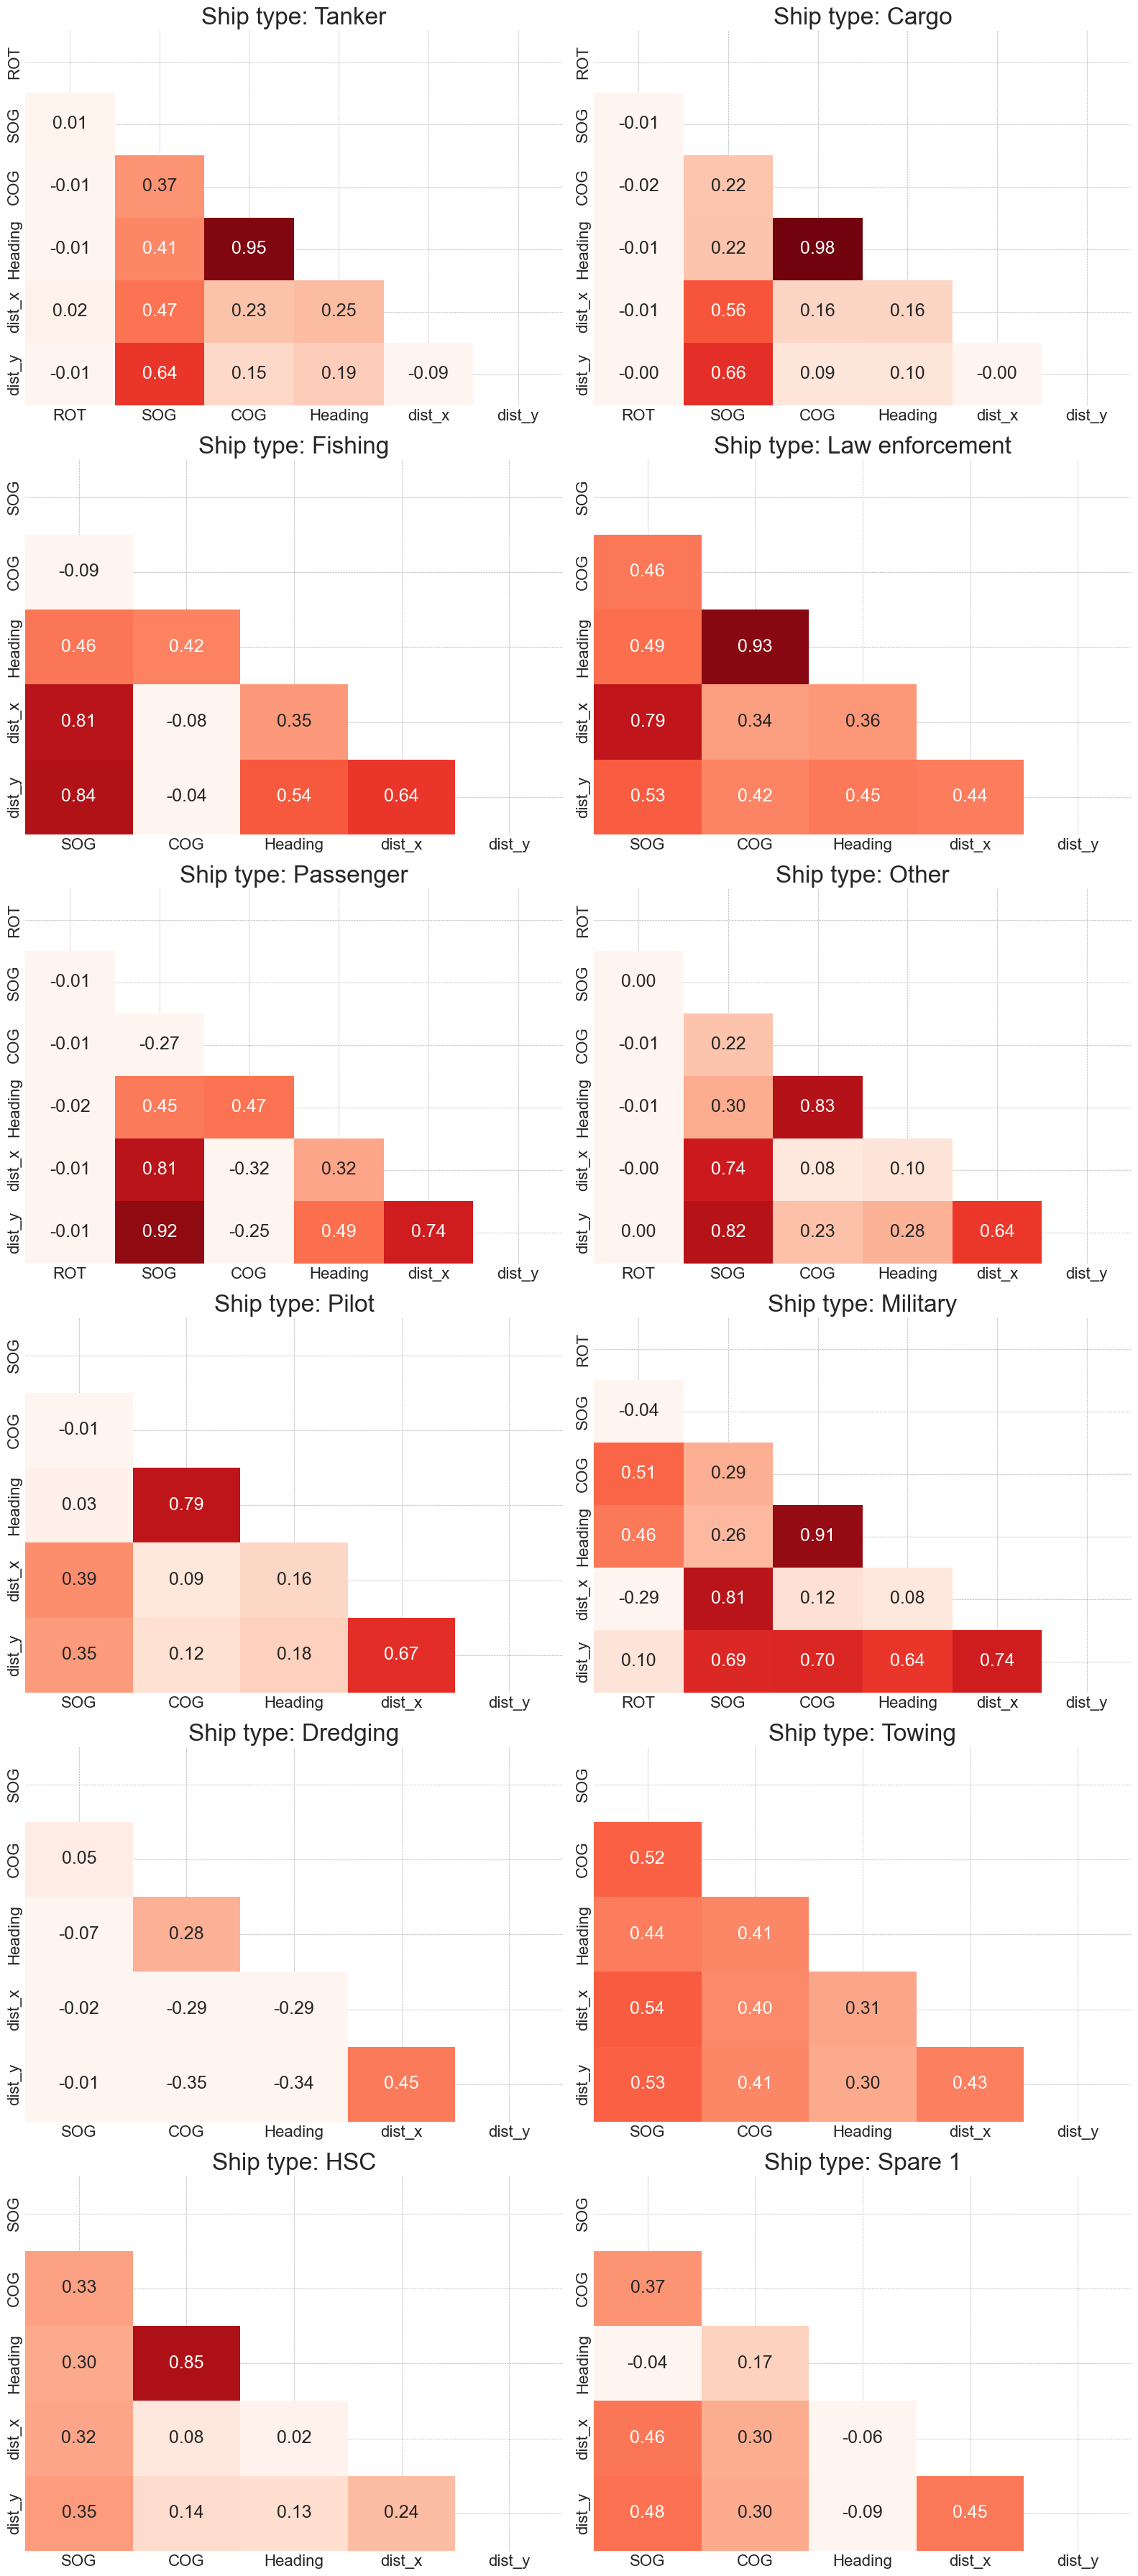

In [156]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

ship_types = data["Ship type"].dropna().unique()

n = len(ship_types)
cols = 2  # kiek heatmap vienoje eilėje
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows))
axes = axes.flatten()

for i, ship_type in enumerate(ship_types):
    
    subset = data[data["Ship type"] == ship_type]
    
    columns = numerical.copy()
    if subset['ROT'].nunique() == 1:
        columns.remove('ROT')

    corr = subset[columns].corr(method="spearman")
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(
        corr,
        mask=mask,
        cmap="Reds",
        annot=True,
        fmt=".2f",
        ax=axes[i],
        cbar=False,
        annot_kws={"fontsize": 18},
        vmin=0,
        vmax=1
    )
    
    axes[i].set_title(f"Ship type: {ship_type}", size=24)
    axes[i].tick_params(axis='both', labelsize=16)

# Paslepiame nenaudojamus subplot'us jei jų liko
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('plots/1lab/corr-matrices.png', dpi=750)
plt.show()


## Aprasomoji statistika, palyginimoji analizė

### Aprasomoji statistika

In [157]:
import pandas as pd

numeric_cols = data[numerical]

Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
min_vals = numeric_cols.min()
max_vals = numeric_cols.max()

desc_stats = pd.DataFrame({
    'min': min_vals,
    'Q1': Q1,
    'median': numeric_cols.median(),
    'mean': numeric_cols.mean(),
    'Q3': Q3,
    'IQR': Q3 - Q1,
    'max': max_vals,
    'range': max_vals - min_vals,
    'variance': numeric_cols.var(),
    'std_dev': numeric_cols.std()
})

pd.options.display.float_format = '{:.3f}'.format
print(desc_stats)


           min     Q1  median   mean     Q3   IQR   max  range  variance  \
ROT     -6.784 -0.003  -0.003  0.000 -0.003 0.000 6.940 13.724     1.000   
SOG     -1.563 -0.670   0.164 -0.000  0.655 1.324 3.539  5.102     1.000   
COG     -2.095 -0.685   0.026 -0.000  0.695 1.379 2.164  4.259     1.000   
Heading -2.215 -0.599  -0.014  0.000  0.695 1.293 2.262  4.477     1.000   
dist_x  -1.022 -0.904  -0.220  0.000  0.568 1.473 8.880  9.902     1.000   
dist_y  -1.304 -0.947   0.018  0.000  0.682 1.629 9.190 10.494     1.000   

         std_dev  
ROT        1.000  
SOG        1.000  
COG        1.000  
Heading    1.000  
dist_x     1.000  
dist_y     1.000  


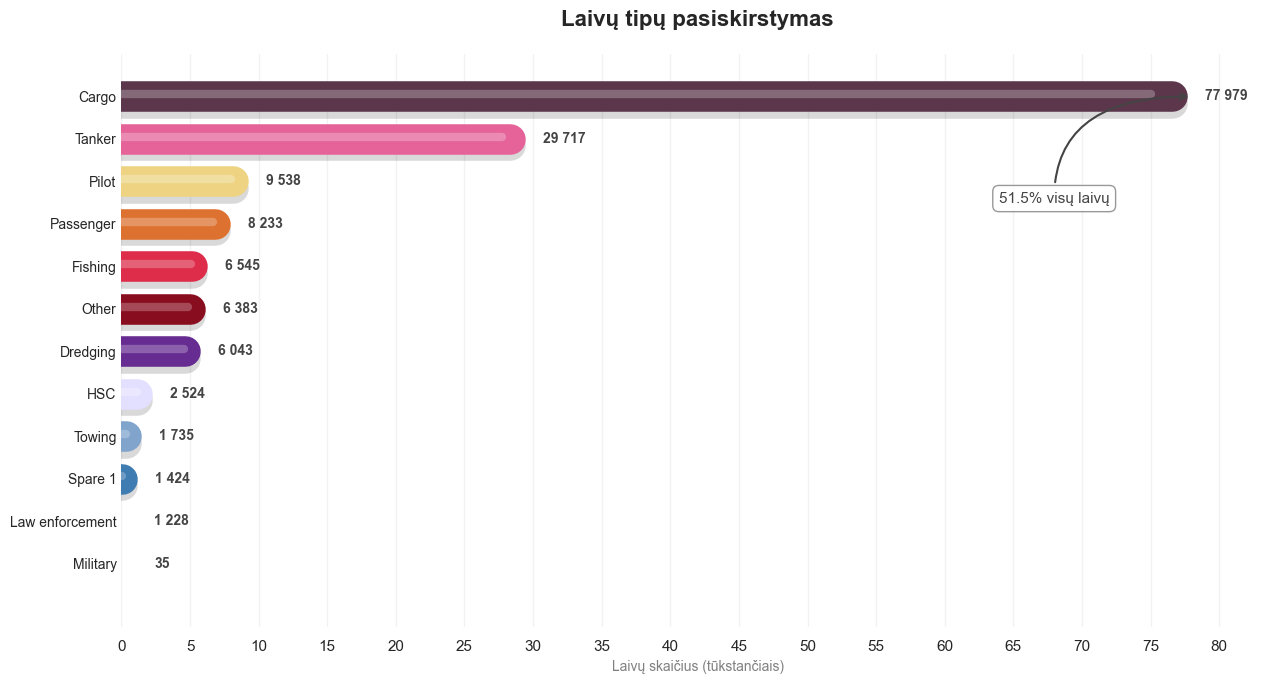

In [175]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Data Preparation
ship_counts = data["Ship type"].value_counts().sort_values(ascending=True)

palette = [
    "#02010A","#140152","#3E7CB1","#81A4CD",
    "#E3DFFF","#662C91","#880D1E","#DD2D4A",
    "#DD7230","#EDD382","#E56399","#5C374C"
]
colors = palette[:len(ship_counts)]

# Calculations
total_ships = ship_counts.sum()
top_val = ship_counts.values[-1]
top_pct = (top_val / total_ships) * 100

# Setup
fig, ax = plt.subplots(figsize=(13, 7)) 
y_pos = np.arange(len(ship_counts))

# --- CORRECTION FACTOR FOR ROUND CAPS ---
# This ensures bars don't look longer than their value.
cap_correction = 1400 

# LOGIC UPDATE: 
# If value > cap_correction: Subtract correction to be accurate.
# If value is tiny: Set length to 0.001 (not 0) so the round cap still renders as a 'dot'.
visual_lengths = [max(x - cap_correction, 0.001) for x in ship_counts.values]

# --- THE VISUAL LAYERS ---

# Layer 1: Drop Shadow
ax.hlines(
    y=y_pos - 0.15, 
    xmin=0, xmax=visual_lengths, 
    color='black', alpha=0.15, linewidth=22, capstyle='round'
)

# Layer 2: Main Bar
ax.hlines(
    y=y_pos, 
    xmin=0, xmax=visual_lengths, 
    color=colors, linewidth=22, capstyle='round'
)

# Layer 3: Glossy Highlight
ax.hlines(
    y=y_pos + 0.05,
    xmin=0, xmax=np.array(visual_lengths) * 0.98,
    color='white', alpha=0.25, linewidth=6, capstyle='round'
)

# --- SMART LABELS ---

for y, value in zip(y_pos, ship_counts.values):
    label_text = f"{value:,}".replace(',', ' ')
    
    # LOGIC UPDATE:
    # If the value is tiny (e.g., 35), the visual 'dot' (radius ~1400) is wider than the data.
    # We must place the text to the right of the *visual cap*, not the data value.
    text_x_pos = max(value, cap_correction) + 1000
    
    ax.text(
        text_x_pos, 
        y, 
        label_text, 
        va='center', 
        fontsize=10, 
        fontweight='bold', 
        color='#444444'
    )

# --- ANNOTATIONS ---

ax.annotate(
    f"{top_pct:.1f}% visų laivų",
    xy=(top_val, len(ship_counts)-1),  
    xytext=(top_val - 10000, len(ship_counts)-3.5), 
    ha='center',
    arrowprops=dict(
        arrowstyle="->", 
        color="#444444",
        connectionstyle="angle3,angleA=90,angleB=0", 
        lw=1.5
    ),
    fontsize=11, 
    color="#444444",
    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8)
)

# --- AXIS FORMATTING ---

ax.xaxis.set_major_locator(ticker.MultipleLocator(5000))

def thousands_formatter(x, pos):
    return f'{int(x/1000)}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

# --- FINAL STYLING ---

ax.set_yticks(y_pos)
ax.set_yticklabels(ship_counts.index, fontsize=10, fontweight='medium')

ax.set_xlim(0, 84000) 
ax.set_ylim(-1.5, len(ship_counts))

ax.set_xlabel("Laivų skaičius (tūkstančiais)", fontsize=10, color='gray')
ax.set_title("Laivų tipų pasiskirstymas", fontsize=16, fontweight='bold', pad=20)

ax.grid(axis='y', visible=False)
ax.grid(axis='x', color='gray', alpha=0.1, linewidth=1)
ax.set_axisbelow(True)

ax.spines[['top','right','left', 'bottom']].set_visible(False)
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', color='gray')

plt.tight_layout()
plt.show()

### Palyginamoji analizė

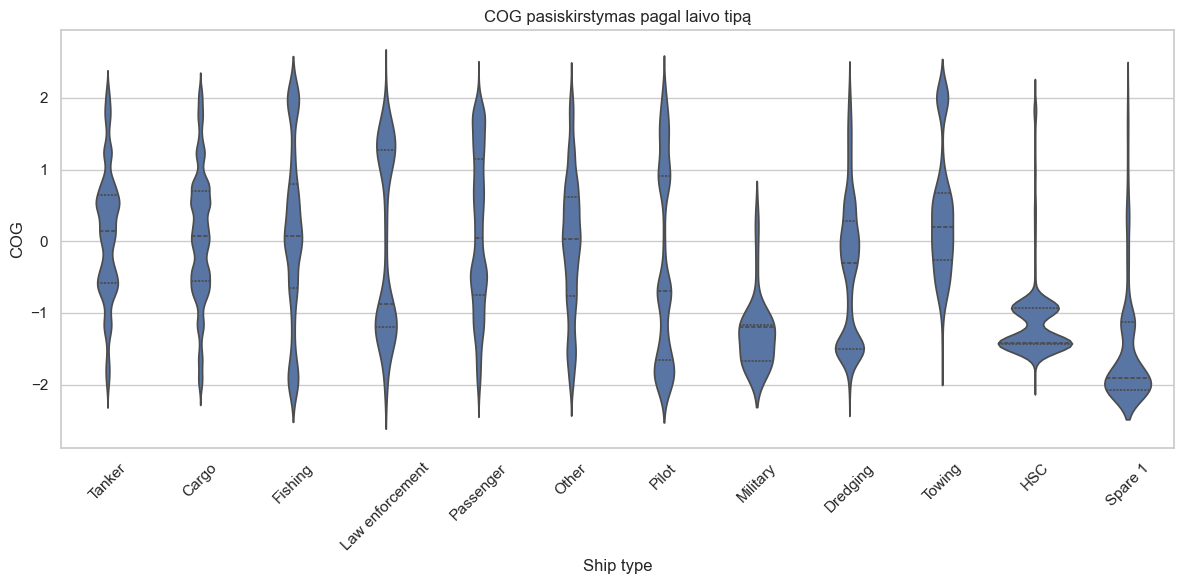

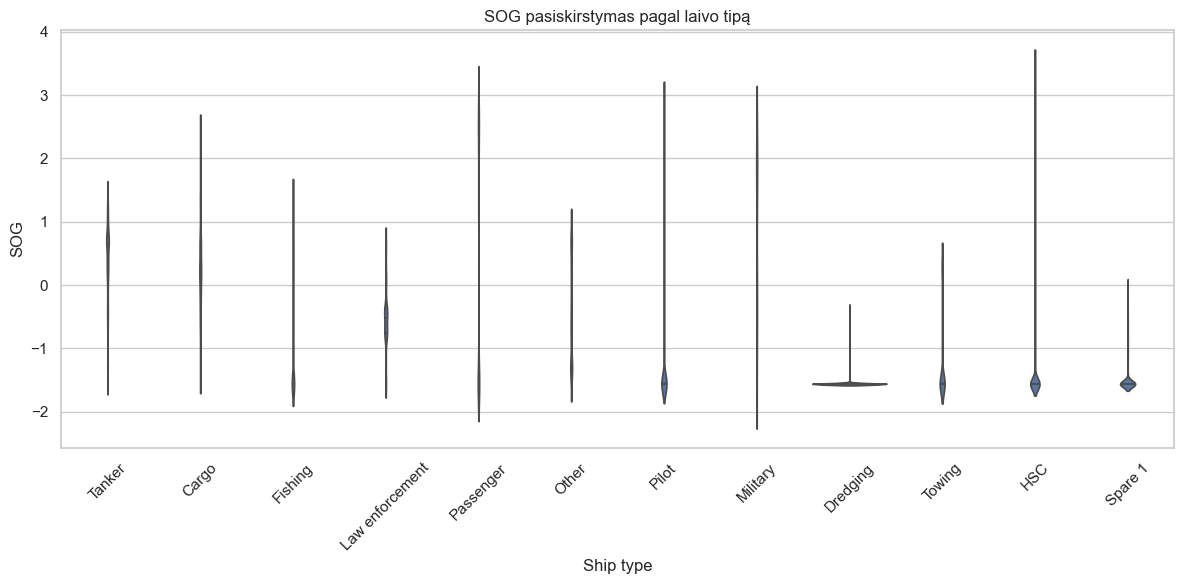

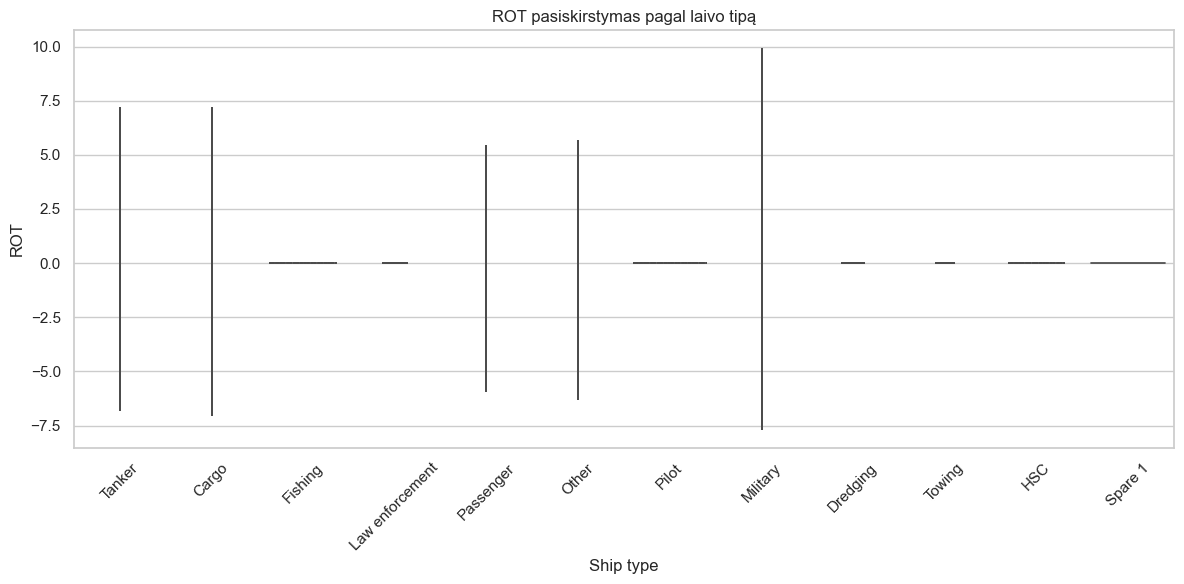

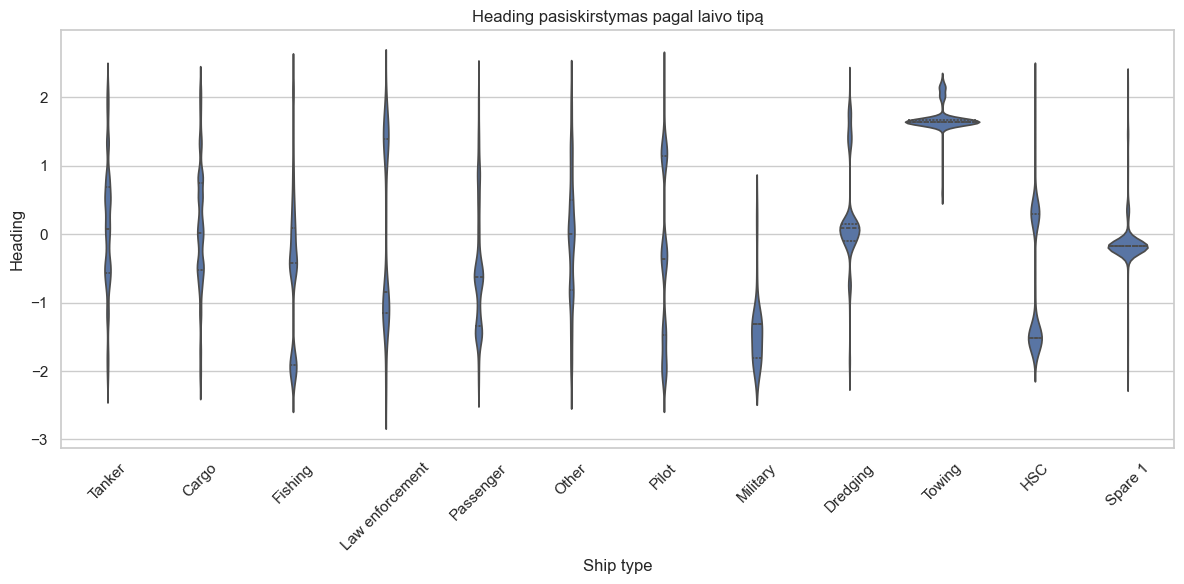

In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin_by_shiptype(df, variables):
    
    dfp = df.dropna(subset=["Ship type"]).copy()
    dfp["Ship type"] = dfp["Ship type"].astype(str).str.strip()
    
    variables = [
        col for col in variables 
        if col in dfp.columns and pd.api.types.is_numeric_dtype(dfp[col])
    ]
    
    sns.set_theme(style="whitegrid")
    
    for var in variables:
        
        plt.figure(figsize=(12, 6))
        
        sns.violinplot(
            data=dfp,
            x="Ship type",
            y=var,
            inner="quartile"
        )
        
        plt.xticks(rotation=45)
        plt.title(f"{var} pasiskirstymas pagal laivo tipą")
        plt.xlabel("Ship type")
        plt.ylabel(var)
        
        plt.tight_layout()
        plt.show()


# Kintamieji
selected_vars = ["COG", "SOG", "ROT", "Heading"]

plot_violin_by_shiptype(data, selected_vars)


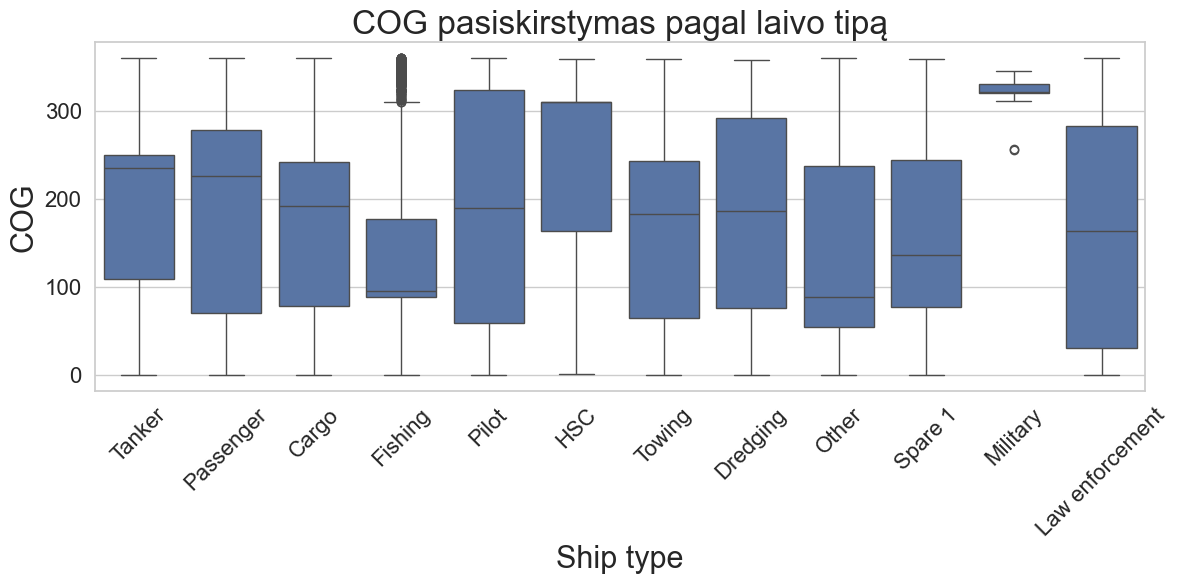

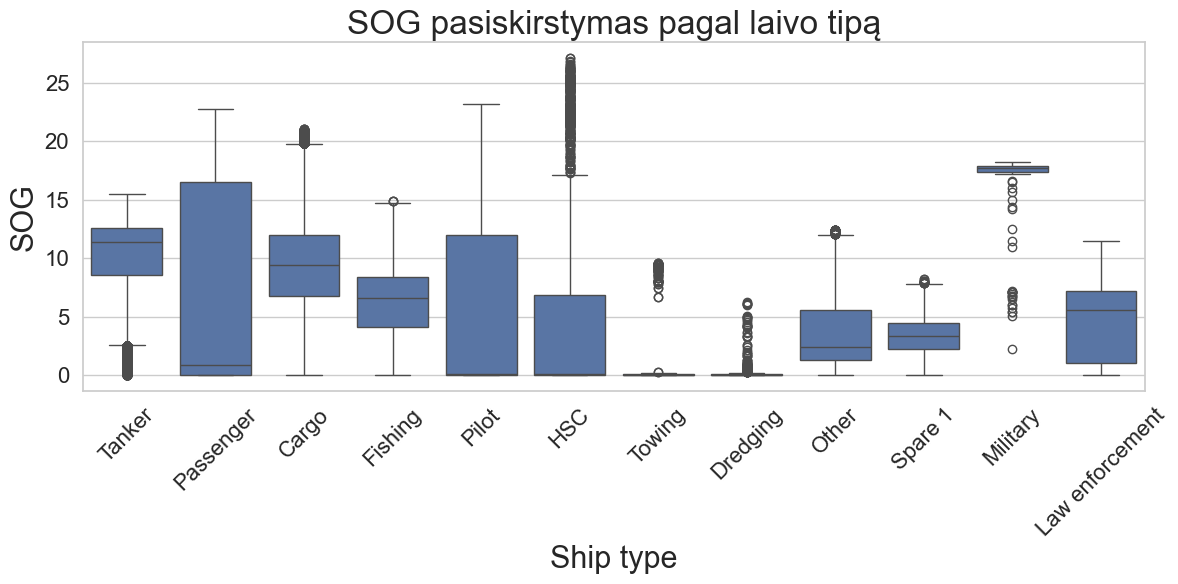

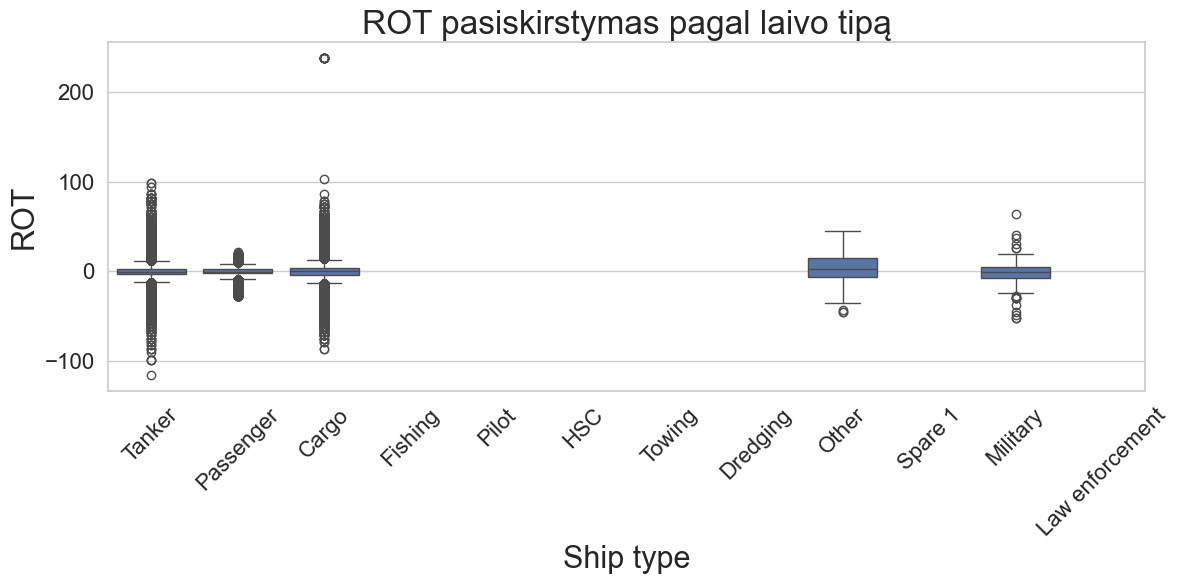

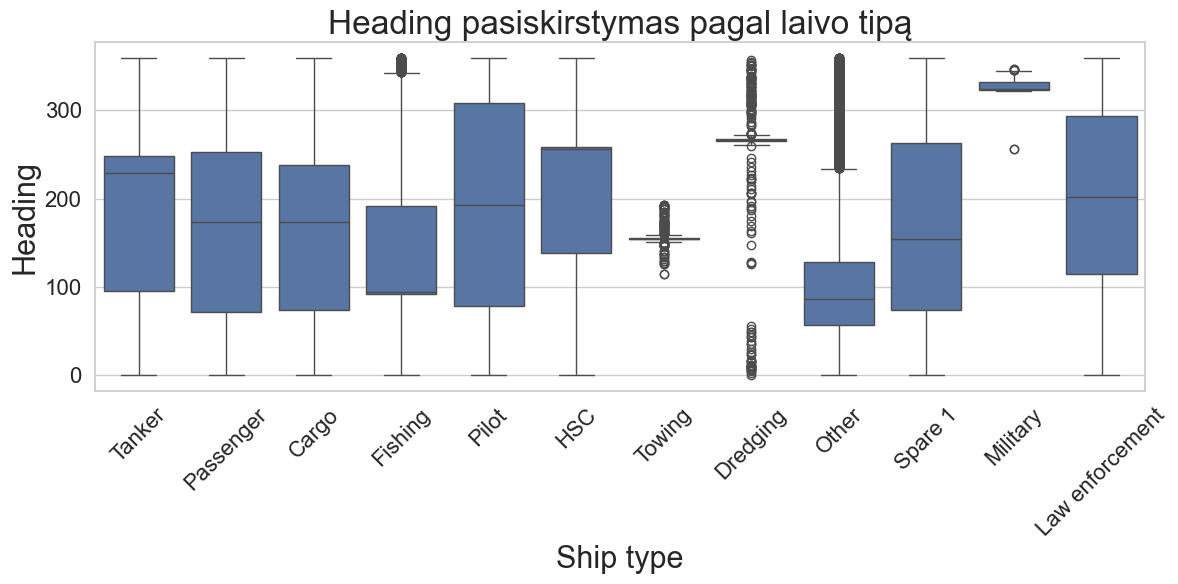

In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_box_by_shiptype(df, variables):
    
    dfp = df.dropna(subset=["Ship type"]).copy()
    dfp["Ship type"] = dfp["Ship type"].astype(str).str.strip()
    
    variables = [
        col for col in variables 
        if col in dfp.columns and pd.api.types.is_numeric_dtype(dfp[col])
    ]
    
    sns.set_theme(style="whitegrid")
    
    for var in variables:
        
        plt.figure(figsize=(12, 6))
        
        sns.boxplot(
            data=dfp,
            x="Ship type",
            y=var
        )
        
        plt.xticks(rotation=45)
        plt.title(f"{var} pasiskirstymas pagal laivo tipą", size=24)
        plt.xlabel("Ship type", size=22)
        plt.ylabel(var, size=22)
        plt.tick_params(axis='both', labelsize=16)

        plt.tight_layout()
        plt.savefig(f'plots/1lab/boxplot-{var}.png', dpi=750)
        plt.show()


# Kintamieji
selected_vars = ["COG", "SOG", "ROT", "Heading"]

plot_box_by_shiptype(df_isskirciu, selected_vars)


## Sekų formavimas